# Journal 2022-08-29

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import sympy as sp

In [14]:
sp.init_printing(use_latex=True)

# Constant Function Market Maker Maths
Below we consider the mathematics of a Uniswap V2 style CFMM

In [68]:
x, y, w_x, w_y, k, p_s, v_s  = sp.symbols('x y w_x w_y k p v', positive=True)
d_x, d_y, d_w = sp.symbols('Delta_x Delta_y Delta_w', real=True)

Start with the invariant equation

In [69]:
inv_eqn = sp.Eq(k, x**w_x*y**w_y).subs({w_y: 1- w_x})
inv_eqn

We can solve for the weight in terms of the invariant and token balances

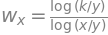

In [70]:
wt_eqn = sp.Eq(w_x, sp.solve(inv_eqn, w_x)[0])
wt_eqn

A swap preserves the invariant so we can use this to solve for change in token balances.  Here we assume $\Delta_x$ x tokens go into the CFMM, $\Delta_y$ y tokens go out

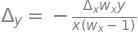

In [71]:
swap_eqn = sp.Eq(
    d_y, 
    sp.series(
        sp.solve(sp.Eq(inv_eq, inv_eqn.subs({x: x + d_x, y: y - d_y})), d_y)[0],
        d_x, n=2
    ).removeO().simplify()
)
swap_eqn

The spot price of the y token interms of x is given by the gradient dx/dy 

In [72]:
price_eqn = sp.Eq(
    p_s, d_x/d_y.subs({d_y: swap_eqn.rhs})
).simplify()
price_eqn

The total portfolio value contained in the CFMM is $x + p y$ for spot price p, which simplifies

In [104]:
value_eqn = sp.Eq(
    v_s, x + y*price_eqn.rhs
).simplify()
value_eqn

In [105]:
jac_eqn = sp.Matrix(
    [inv_eqn.rhs, price_eqn.rhs, value_eqn.rhs]
).jacobian([x, y, w_x]).applyfunc(sp.simplify)
jac_eqn

⎡                                       ⎛    wₓ  1 - wₓ⎞⎤
⎢                       wₓ              ⎜   x  ⋅y      ⎟⎥
⎢    wₓ - 1  1 - wₓ  ⎛x⎞                ⎜⎛x⎞           ⎟⎥
⎢wₓ⋅x      ⋅y        ⎜─⎟  ⋅(1 - wₓ)  log⎜⎜─⎟           ⎟⎥
⎢                    ⎝y⎠                ⎝⎝y⎠           ⎠⎥
⎢                                                       ⎥
⎢      1 - wₓ          x⋅(wₓ - 1)            -x         ⎥
⎢      ──────          ──────────           ─────       ⎥
⎢       wₓ⋅y                 2                2         ⎥
⎢                        wₓ⋅y               wₓ ⋅y       ⎥
⎢                                                       ⎥
⎢        1                                   -x         ⎥
⎢        ──                0                 ───        ⎥
⎢        wₓ                                    2        ⎥
⎣                                            wₓ         ⎦

In [106]:
const_val_wt_eqn = sp.Eq(d_w, sp.solve(jac_eqn[2,0]*d_x - jac_eqn[2,1]*d_y + jac_eqn[2,2]*d_w, d_w)[0])
const_val_wt_eqn

In [107]:
jac_eqn @ sp.Matrix([d_x, swap_eqn.rhs, const_val_wt_eqn.rhs]).applyfunc(sp.simplify)

⎡                                                          ⎛    wₓ  1 - wₓ⎞⎤
⎢                                   wₓ                     ⎜   x  ⋅y      ⎟⎥
⎢                                ⎛x⎞                       ⎜⎛x⎞           ⎟⎥
⎢                        Δₓ⋅wₓ⋅y⋅⎜─⎟  ⋅(1 - wₓ)   Δₓ⋅wₓ⋅log⎜⎜─⎟           ⎟⎥
⎢       wₓ - 1  1 - wₓ           ⎝y⎠                       ⎝⎝y⎠           ⎠⎥
⎢Δₓ⋅wₓ⋅x      ⋅y       - ────────────────────── + ─────────────────────────⎥
⎢                              x⋅(wₓ - 1)                     x            ⎥
⎢                                                                          ⎥
⎢                          Δₓ   Δₓ⋅(1 - wₓ)    Δₓ                          ⎥
⎢                        - ── + ─────────── - ────                         ⎥
⎢                          y        wₓ⋅y      wₓ⋅y                         ⎥
⎢                                                                          ⎥
⎣                                    0                                     ⎦

In [108]:
diff_eqn @ sp.Matrix([d_x, swap_eqn.rhs, 0]).applyfunc(sp.simplify)

⎡                                   wₓ         ⎤
⎢                                ⎛x⎞           ⎥
⎢                        Δₓ⋅wₓ⋅y⋅⎜─⎟  ⋅(1 - wₓ)⎥
⎢       wₓ - 1  1 - wₓ           ⎝y⎠           ⎥
⎢Δₓ⋅wₓ⋅x      ⋅y       - ──────────────────────⎥
⎢                              x⋅(wₓ - 1)      ⎥
⎢                                              ⎥
⎢                Δₓ   Δₓ⋅(1 - wₓ)              ⎥
⎢              - ── + ───────────              ⎥
⎢                y        wₓ⋅y                 ⎥
⎢                                              ⎥
⎢                      Δₓ                      ⎥
⎢                      ──                      ⎥
⎣                      wₓ                      ⎦